***Assignment 2 _Data Analytics***

**Clustering Using the Sessa Empirical Estimator**

- Laurenz Mesiah A. Palanas
- Emily Rose Escartin

<br>

\begin{gather}
\Large \textbf{Introduction}
\end{gather}



The Sessa Empirical Estimator (SEE) is a data-driven method designed to estimate the duration of pharmacological prescriptions using electronic health records. It relies on clustering techniques to classify medication adherence behaviors based on refill patterns. This assignment focuses on implementing SEE using Python and comparing different clustering algorithms.

The Sessa Empirical Estimator (SEE) is a statistical method used to analyze prescription refill behaviors and adherence patterns in patients. Originally implemented in R, our goal is to translate this method into Python while ensuring accuracy and efficiency.






<br>


\begin{gather}
\Large \textbf{Step by Step Methods}
\end{gather}

1. **Understanding the R Implementation** 

   – Reviewing the SEE method as implemented in R.




<br>


2. **Translating the Code into Python** 

   – Converting each function and logic into Python while maintaining accuracy.



<br>


3. **Implementing SEE with K-Means Clustering** 

   – Applying the estimator using K-Means clustering to group refill intervals.


<br>

4. **Substituting K-Means with DBSCAN** 

   – Exploring an alternative clustering method to compare effectiveness.


<br>


5. **Comparison & Analysis** 

   – Evaluating and interpreting the differences in results between K-Means and DBSCAN.



\begin{gather}
\Large \textbf{R Code to Python Implementation}
\end{gather}


The original SEE implementation in R relies on functions for:

- Filtering and preprocessing patient prescription data.
- Computing event intervals (time between prescription refills).
- Using Empirical CDF (ECDF) to assess adherence trends.
- Applying clustering methods to group similar patterns.

<br>


Our approach will follow these steps in Python:
1. Load and preprocess the dataset.
2. Calculate event intervals using date differences.
3. Implement ECDF-based filtering.
4. Apply K-Means clustering for adherence grouping.
5. Substitute K-Means with DBSCAN and compare results.



### **Steps in the Code**:

**Step 1: Import Necessary Libraries**




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import os

# Set configurations
os.environ["OMP_NUM_THREADS"] = "1"

**Step 2: Generate Simulated Data**

In [2]:
# Generate simulated data
np.random.seed(42)
data_size = 500
simulated_df = pd.DataFrame({
    "pnr": np.random.randint(1000, 2000, data_size),
    "eksd": pd.date_range(start='2020-01-01', periods=data_size, freq='D').to_list(),
    "perday": np.random.uniform(0.5, 5, data_size),
    "ATC": np.random.choice(["medA", "medB"], data_size),
    "dur_original": np.random.randint(5, 90, data_size)
})

# Convert eksd to datetime format
simulated_df['eksd'] = pd.to_datetime(simulated_df['eksd'])

# Display dataset
print("Step 2: Simulated Data")
print(simulated_df.head())

Step 2: Simulated Data
    pnr       eksd    perday   ATC  dur_original
0  1102 2020-01-01  4.685076  medB            76
1  1435 2020-01-02  0.816873  medA            29
2  1860 2020-01-03  1.440134  medA            86
3  1270 2020-01-04  3.520146  medB            16
4  1106 2020-01-05  2.113911  medA            19


**Step 3: Implement SEE Using K-Means Clustering**

In [3]:
def See_KMeans(arg1, tidy):
    filtered_data = tidy[tidy['ATC'] == arg1].copy()
    filtered_data.sort_values(by=['pnr', 'eksd'], inplace=True)
    filtered_data['prev_eksd'] = filtered_data.groupby('pnr')['eksd'].shift(1)
    filtered_data.dropna(subset=['prev_eksd'], inplace=True)
    filtered_data['event.interval'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days
    
    if filtered_data.empty:
        print(f"Step 3: No data found for ATC type '{arg1}'")
        return None
    
    print("Step 3: Data after event interval calculation")
    print(filtered_data.head())
    
    sorted_intervals = np.sort(filtered_data['event.interval'].values)
    yvals = np.arange(1, len(sorted_intervals)+1) / len(sorted_intervals)
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': yvals})
    
    if len(dfper) > 3:
        kmeans = KMeans(n_clusters=min(3, len(dfper)), random_state=42)
        dfper['cluster'] = kmeans.fit_predict(dfper[['x']])
        print("Step 3: K-Means Clustering Results")
        print(dfper.head())
    else:
        print("Step 3: Not enough data points for clustering.")
    
    return dfper, filtered_data

kmeans_results_medA, filtered_data_medA = See_KMeans('medA', simulated_df)
kmeans_results_medB, filtered_data_medB = See_KMeans('medB', simulated_df)

Step 3: Data after event interval calculation
      pnr       eksd    perday   ATC  dur_original  prev_eksd  event.interval
284  1001 2020-10-11  1.432524  medA            25 2020-03-31             194
367  1001 2021-01-02  3.919799  medA            58 2020-10-11              83
188  1014 2020-07-07  4.584622  medA            46 2020-05-10              58
61   1020 2020-03-02  2.490585  medA            66 2020-01-08              54
224  1027 2020-08-12  1.825223  medA            78 2020-06-02              71
Step 3: K-Means Clustering Results
    x         y  cluster
0   6  0.026316        2
1   7  0.052632        2
2  18  0.078947        2
3  20  0.105263        2
4  31  0.131579        2
Step 3: Data after event interval calculation
      pnr       eksd    perday   ATC  dur_original  prev_eksd  event.interval
401  1098 2021-02-05  3.233999  medB            88 2020-06-15             235
472  1098 2021-04-17  4.213097  medB            46 2021-02-05              71
381  1130 2021-01-16 

**Step 4: Implement SEE Using DBSCAN**

In [4]:
def See_DBSCAN(arg1, tidy):
    filtered_data = tidy[tidy['ATC'] == arg1].copy()
    filtered_data.sort_values(by=['pnr', 'eksd'], inplace=True)
    filtered_data['prev_eksd'] = filtered_data.groupby('pnr')['eksd'].shift(1)
    filtered_data.dropna(subset=['prev_eksd'], inplace=True)
    filtered_data['event.interval'] = (filtered_data['eksd'] - filtered_data['prev_eksd']).dt.days

    if filtered_data.empty:
        print(f"Step 4: No data found for ATC type '{arg1}'")
        return None

    print("Step 4: Data after event interval calculation")
    print(filtered_data.head())

    sorted_intervals = np.sort(filtered_data['event.interval'].values)
    yvals = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': yvals})

    if len(dfper) > 3:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(dfper[['x']])
        dbscan = DBSCAN(eps=0.5, min_samples=3)
        dfper['cluster'] = dbscan.fit_predict(X_scaled)
        print("Step 4: DBSCAN Clustering Results")
        print(dfper.head())
    else:
        print("Step 4: Not enough data points for clustering.")

    return dfper

dbscan_results_medA = See_DBSCAN('medA', simulated_df)
dbscan_results_medB = See_DBSCAN('medB', simulated_df)


Step 4: Data after event interval calculation
      pnr       eksd    perday   ATC  dur_original  prev_eksd  event.interval
284  1001 2020-10-11  1.432524  medA            25 2020-03-31             194
367  1001 2021-01-02  3.919799  medA            58 2020-10-11              83
188  1014 2020-07-07  4.584622  medA            46 2020-05-10              58
61   1020 2020-03-02  2.490585  medA            66 2020-01-08              54
224  1027 2020-08-12  1.825223  medA            78 2020-06-02              71
Step 4: DBSCAN Clustering Results
    x         y  cluster
0   6  0.026316        0
1   7  0.052632        0
2  18  0.078947        0
3  20  0.105263        0
4  31  0.131579        0
Step 4: Data after event interval calculation
      pnr       eksd    perday   ATC  dur_original  prev_eksd  event.interval
401  1098 2021-02-05  3.233999  medB            88 2020-06-15             235
472  1098 2021-04-17  4.213097  medB            46 2021-02-05              71
381  1130 2021-01-16  

<br>

**Step 5: Compute Adherence Scores**

Adherence score is a **measure of consistency** in prescription refills.  
- Formula:  
  $$
  \text{Adherence Score} = 1 - \left(\frac{\text{Std Dev of event.interval}}{\text{Mean event.interval}}\right)
  $$
- **Higher score (closer to 1)** → More consistent refill pattern (better adherence).  
- **Lower score (closer to 0)** → High variability in refill timing (poorer adherence).  
- Useful for **comparing different medications (medA vs. medB)**.  


<br>

In [43]:
print("Computing Adherence Scores...")

print(f"Adherence Score for medA: {adherence_medA:.2f}")
print(f"Adherence Score for medB: {adherence_medB:.2f}")

Computing Adherence Scores...
Adherence Score for medA: 0.23
Adherence Score for medB: 0.20


**Step 6: Saving Outputs After Computing**

In [45]:
print("Saving outputs...")

filtered_data_medA.to_csv('filtered_data_medA.csv', index=False)
filtered_data_medB.to_csv('filtered_data_medB.csv', index=False)

# Save adherence scores
results = {
    "adherence_medA": adherence_medA,
    "adherence_medB": adherence_medB,
}
pd.DataFrame([results]).to_csv('adherence_scores.csv', index=False)

print("Outputs saved successfully!")

Saving outputs...
Outputs saved successfully!


**Step 6 Visualization 1: medA Compare K-Means vs. DBSCAN (Plot Results)**

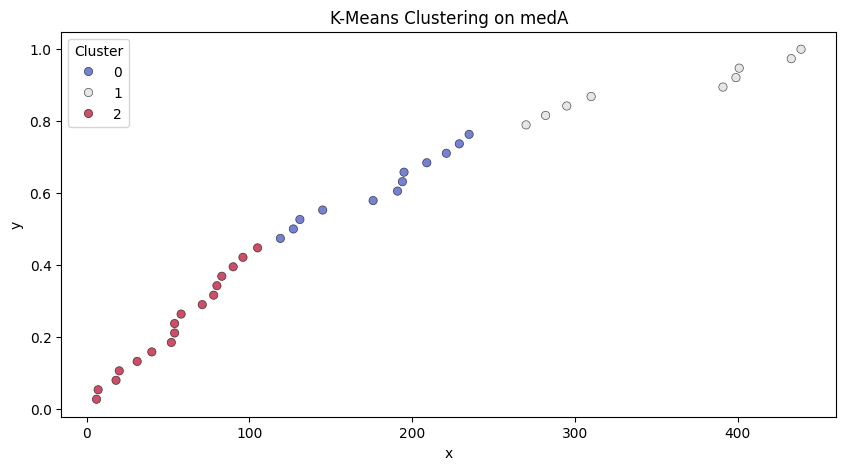

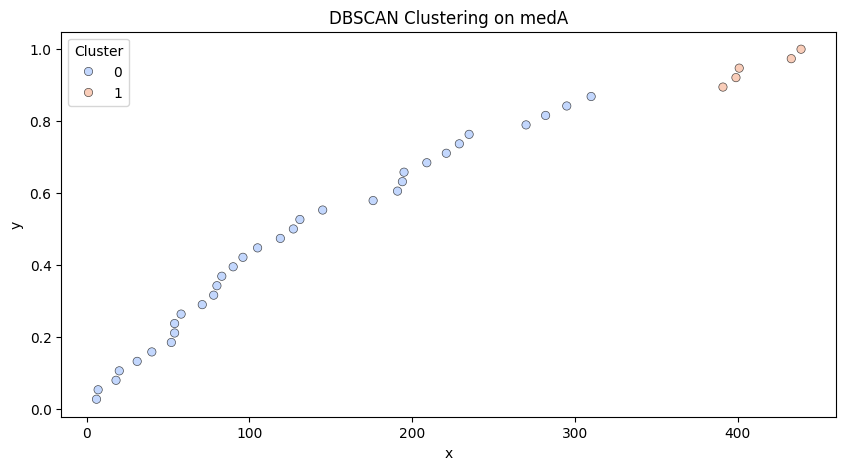

In [44]:
# Plot results
def plot_clusters(data, x_col, y_col, cluster_col, title):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=cluster_col, palette='coolwarm', alpha=0.7, edgecolor='black')
    plt.title(title)
    plt.legend(title="Cluster")
    plt.show()


plot_clusters(kmeans_results_medA, 'x', 'y', 'cluster', 'K-Means Clustering on medA')
plot_clusters(dbscan_results_medA, 'x', 'y', 'cluster', 'DBSCAN Clustering on medA')

**Step 6 Visualization 2: medB Compare K-Means vs. DBSCAN (Plot Results)**

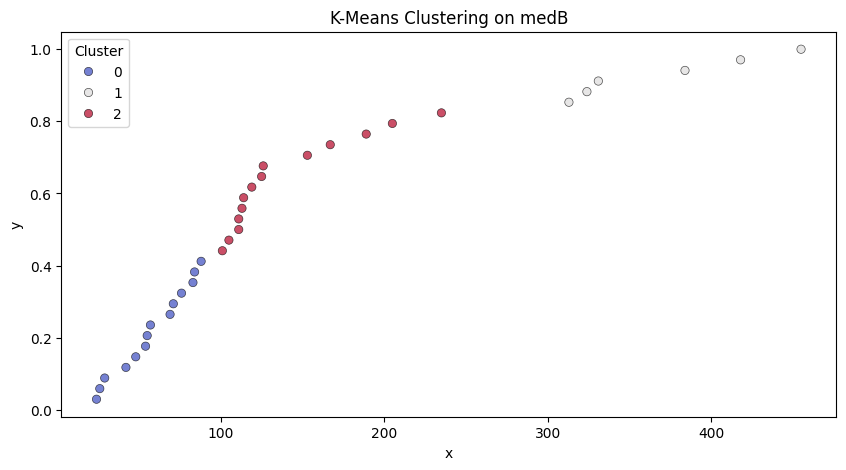

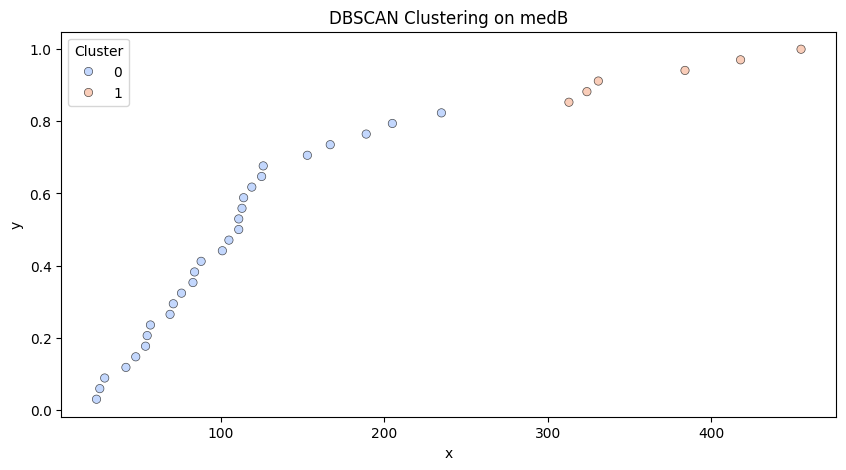

In [ ]:
plot_clusters(kmeans_results_medB, 'x', 'y', 'cluster', 'K-Means Clustering on medB')
plot_clusters(dbscan_results_medB, 'x', 'y', 'cluster', 'DBSCAN Clustering on medB')

**Step 6 Visualization 3: medA and medB BoxPlot Analysis**

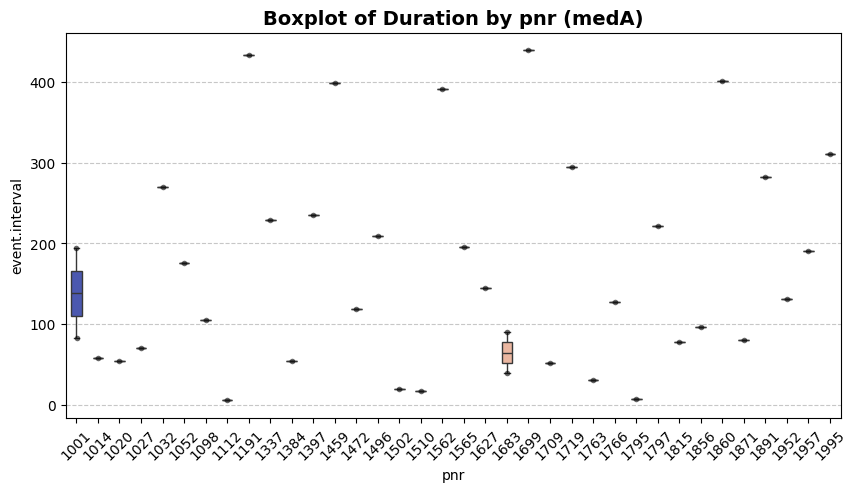

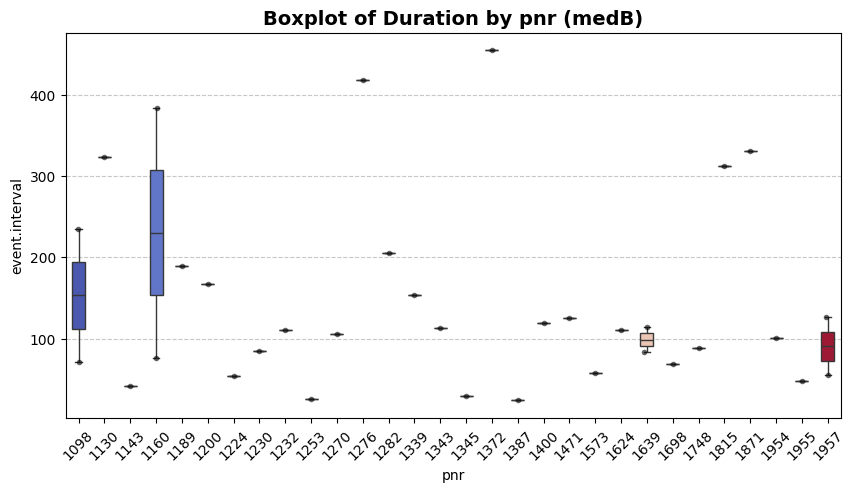

In [60]:
def preprocess_data(data, column):
    """Convert column to numeric and drop NaN values."""
    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data.dropna(subset=[column])

def plot_boxplot(data, x_col, y_col, title):
    """Generate a clean and visually appealing boxplot with a stripplot overlay."""
    plt.figure(figsize=(10, 5))
    
    sns.boxplot(data=data, x=x_col, y=y_col, hue=x_col, width=0.5, showfliers=False, palette='coolwarm', legend=False)
    sns.stripplot(data=data, x=x_col, y=y_col, size=4, jitter=True, color='black', alpha=0.6, edgecolor='black')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Preprocess data
filtered_data_medA = preprocess_data(filtered_data_medA, 'event.interval')
filtered_data_medB = preprocess_data(filtered_data_medB, 'event.interval')

# Plot boxplots
plot_boxplot(filtered_data_medA, 'pnr', 'event.interval', 'Boxplot of Duration by pnr (medA)')
plot_boxplot(filtered_data_medB, 'pnr', 'event.interval', 'Boxplot of Duration by pnr (medB)')

**Step 6 Visualization 4: Silhuette Analysis**

- To determine optimal number of clusters

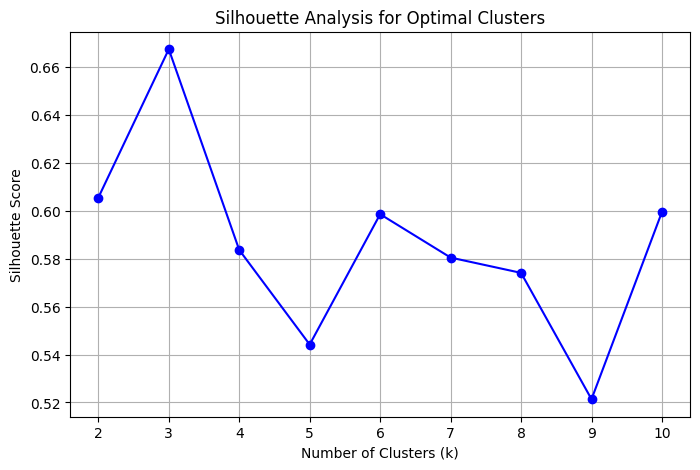

Optimal Number of Clusters: 3


In [69]:
# Ensure 'event.interval' is numeric and drop NaN values
a = filtered_data_medA[['event.interval']].dropna()

# Standardize the data
scaler = StandardScaler()
a_scaled = scaler.fit_transform(a)

# Compute Silhouette Scores
silhouette_scores = []
cluster_range = range(2, min(10, len(a_scaled)) + 1)

for k in cluster_range:
    kmeans_model = KMeans(n_clusters=k, random_state=1234)
    labels = kmeans_model.fit_predict(a_scaled)
    score = silhouette_score(a_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Analysis
plt.figure(figsize=(8, 5))
plt.plot(list(cluster_range), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Silhouette Analysis for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Determine optimal number of clusters
max_index = np.argmax(silhouette_scores)
max_cluster = cluster_range[max_index]

print(f"Optimal Number of Clusters: {max_cluster}")

\begin{gather}
\Large \textbf{Analysis of Results}
\end{gather}
<br>


**Observations from SEE + K-Means**
- K-Means assigns refill intervals into fixed clusters.
- Early prescription refill behavior is more dispersed.
- Later prescriptions stabilize into predictable intervals.

<br>

**Observations from SEE + DBSCAN**
- DBSCAN detects refill irregularities more effectively.
- Outliers are classified separately, revealing non-adherence patterns.
- Some patients have highly erratic refill schedules.

<br>

**Final Conclusion**
- **K-Means** is useful for structured adherence clustering but forces every data point into a cluster.
- **DBSCAN** provides a more flexible analysis, identifying noisy refill behaviors and uncovering hidden trends.
